# Corrective RAG (CRAG)

Self-reflection can enhance RAG, enabling correction of poor quality retrieval
or generations.

Several recent papers focus on this theme, but implementing the ideas can be
tricky.

Here we show how to implement ideas from the `Corrective RAG (CRAG)` paper
[here](https://arxiv.org/pdf/2401.15884.pdf) using LangGraph.

## Dependencies

Set `OPENAI_API_KEY`

Set `TAVILY_API_KEY` to enable web search [here](https://app.tavily.com/sign-in)

## Setup

### Load env vars

Add a `.env` variable in the root of the repo with your variables.

In [1]:
import "dotenv/config";

### Install dependencies

```bash
npm install cheerio zod langchain @langchain/community @langchain/openai @langchain/core @langchain/textsplitters @langchain/langgraph @langchain/tavily
```

## CRAG Detail

Corrective-RAG (CRAG) is a recent paper that introduces an interesting approach
for self-reflective RAG.

The framework grades retrieved documents relative to the question:

1. Correct documents -

- If at least one document exceeds the threshold for relevance, then it proceeds
  to generation
- Before generation, it performns knowledge refinement
- This paritions the document into "knowledge strips"
- It grades each strip, and filters our irrelevant ones

2. Ambiguous or incorrect documents -

- If all documents fall below the relevance threshold or if the grader is
  unsure, then the framework seeks an additional datasource
- It will use web search to supplement retrieval
- The diagrams in the paper also suggest that query re-writing is used here

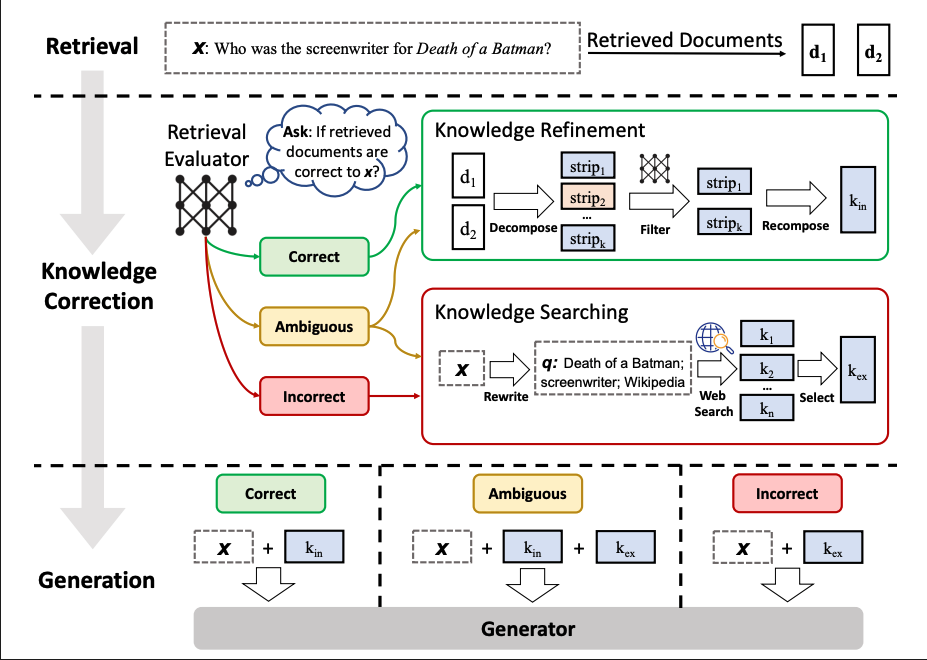

---

Let's implement some of these ideas from scratch using
[LangGraph](https://js.langchain.com/docs/langgraph).

## Retriever

Let's index 3 blog posts.

In [2]:
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio";
import { RecursiveCharacterTextSplitter } from "@langchain/textsplitters";
import { MemoryVectorStore } from "langchain/vectorstores/memory";
import { OpenAIEmbeddings } from "@langchain/openai";

const urls = [
  "https://lilianweng.github.io/posts/2023-06-23-agent/",
  "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
  "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
];

const docs = await Promise.all(
  urls.map((url) => new CheerioWebBaseLoader(url).load()),
);
const docsList = docs.flat();

const textSplitter = new RecursiveCharacterTextSplitter({
  chunkSize: 250,
  chunkOverlap: 0,
});
const docSplits = await textSplitter.splitDocuments(docsList);

// Add to vectorDB
const vectorStore = await MemoryVectorStore.fromDocuments(
  docSplits,
  new OpenAIEmbeddings(),
);
const retriever = vectorStore.asRetriever();

## State

We will define a graph.

Our state will be an `object`.

We can access this from any graph node as `state.key`.

In [3]:
import { Annotation } from "@langchain/langgraph";
import { DocumentInterface } from "@langchain/core/documents";

// Represents the state of our graph.
const GraphState = Annotation.Root({
  documents: Annotation<DocumentInterface[]>({
    reducer: (x, y) => y ?? x ?? [],
  }),
  question: Annotation<string>({
    reducer: (x, y) => y ?? x ?? "",
  }),
  generation: Annotation<string>({
    reducer: (x, y) => y ?? x,
  }),
});

## Nodes and Edges

Each `node` will simply modify the `state`.

Each `edge` will choose which `node` to call next.

We can make some simplifications from the paper:

- Let's skip the knowledge refinement phase as a first pass. This can be added
  back as a node, if desired.
- If _any_ document is irrelevant, let's opt to supplement retrieval with web
  search.
- We'll use
  [Tavily Search](https://js.langchain.com/docs/integrations/tools/tavily_search)
  for web search.
- Let's use query re-writing to optimize the query for web search.

Here is our graph flow:

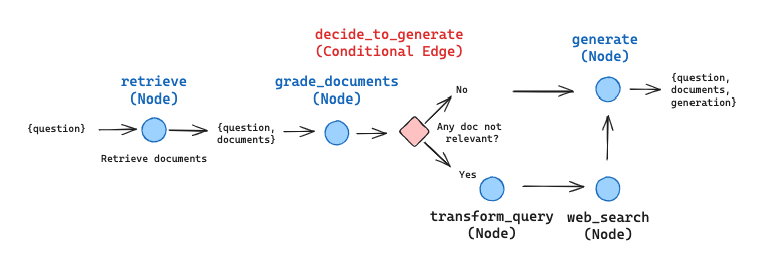

In [ ]:
import { TavilySearch } from "@langchain/tavily";
import { Document } from "@langchain/core/documents";
import { z } from "zod";
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { pull } from "langchain/hub";
import { ChatOpenAI } from "@langchain/openai";
import { StringOutputParser } from "@langchain/core/output_parsers";
import { formatDocumentsAsString } from "langchain/util/document";

// Define the LLM once. We'll reuse it throughout the graph.
const model = new ChatOpenAI({
  model: "gpt-4o",
  temperature: 0,
});

/**
 * Retrieve documents
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function retrieve(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---RETRIEVE---");

  const documents = await retriever
    .withConfig({ runName: "FetchRelevantDocuments" })
    .invoke(state.question);

  return {
    documents,
  };
}

/**
 * Generate answer
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function generate(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---GENERATE---");

  const prompt = await pull<ChatPromptTemplate>("rlm/rag-prompt");
  // Construct the RAG chain by piping the prompt, model, and output parser
  const ragChain = prompt.pipe(model).pipe(new StringOutputParser());

  const generation = await ragChain.invoke({
    context: formatDocumentsAsString(state.documents),
    question: state.question,
  });

  return {
    generation,
  };
}

/**
 * Determines whether the retrieved documents are relevant to the question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function gradeDocuments(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---CHECK RELEVANCE---");

  // pass the name & schema to `withStructuredOutput` which will force the model to call this tool.
  const llmWithTool = model.withStructuredOutput(
    z
      .object({
        binaryScore: z
          .enum(["yes", "no"])
          .describe("Relevance score 'yes' or 'no'"),
      })
      .describe(
        "Grade the relevance of the retrieved documents to the question. Either 'yes' or 'no'."
      ),
    {
      name: "grade",
    }
  );

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing relevance of a retrieved document to a user question.
  Here is the retrieved document:
  
  {context}
  
  Here is the user question: {question}

  If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.`
  );

  // Chain
  const chain = prompt.pipe(llmWithTool);

  const filteredDocs: Array<DocumentInterface> = [];
  for await (const doc of state.documents) {
    const grade = await chain.invoke({
      context: doc.pageContent,
      question: state.question,
    });
    if (grade.binaryScore === "yes") {
      console.log("---GRADE: DOCUMENT RELEVANT---");
      filteredDocs.push(doc);
    } else {
      console.log("---GRADE: DOCUMENT NOT RELEVANT---");
    }
  }

  return {
    documents: filteredDocs,
  };
}

/**
 * Transform the query to produce a better question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function transformQuery(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---TRANSFORM QUERY---");

  // Pull in the prompt
  const prompt = ChatPromptTemplate.fromTemplate(
    `You are generating a question that is well optimized for semantic search retrieval.
  Look at the input and try to reason about the underlying sematic intent / meaning.
  Here is the initial question:
  \n ------- \n
  {question} 
  \n ------- \n
  Formulate an improved question: `
  );

  // Prompt
  const chain = prompt.pipe(model).pipe(new StringOutputParser());
  const betterQuestion = await chain.invoke({ question: state.question });

  return {
    question: betterQuestion,
  };
}

/**
 * Web search based on the re-phrased question using Tavily API.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function webSearch(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---WEB SEARCH---");

  const tool = new TavilySearch();
  const docs = await tool.invoke({ query: state.question });
  const webResults = new Document({ pageContent: docs });
  const newDocuments = state.documents.concat(webResults);

  return {
    documents: newDocuments,
  };
}

/**
 * Determines whether to generate an answer, or re-generate a question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @returns {"transformQuery" | "generate"} Next node to call
 */
function decideToGenerate(state: typeof GraphState.State) {
  console.log("---DECIDE TO GENERATE---");

  const filteredDocs = state.documents;
  if (filteredDocs.length === 0) {
    // All documents have been filtered checkRelevance
    // We will re-generate a new query
    console.log("---DECISION: TRANSFORM QUERY---");
    return "transformQuery";
  }

  // We have relevant documents, so generate answer
  console.log("---DECISION: GENERATE---");
  return "generate";
}


## Build Graph

The just follows the flow we outlined in the figure above.

In [5]:
import { END, START, StateGraph } from "@langchain/langgraph";

const workflow = new StateGraph(GraphState)
  // Define the nodes
  .addNode("retrieve", retrieve)
  .addNode("gradeDocuments", gradeDocuments)
  .addNode("generate", generate)
  .addNode("transformQuery", transformQuery)
  .addNode("webSearch", webSearch);

// Build graph
workflow.addEdge(START, "retrieve");
workflow.addEdge("retrieve", "gradeDocuments");
workflow.addConditionalEdges(
  "gradeDocuments",
  decideToGenerate,
);
workflow.addEdge("transformQuery", "webSearch");
workflow.addEdge("webSearch", "generate");
workflow.addEdge("generate", END);

// Compile
const app = workflow.compile();

In [6]:
const inputs = {
  question: "Explain how the different types of agent memory work.",
};
const config = { recursionLimit: 50 };
let finalGeneration;
for await (const output of await app.stream(inputs, config)) {
  for (const [key, value] of Object.entries(output)) {
    console.log(`Node: '${key}'`);
    // Optional: log full state at each node
    // console.log(JSON.stringify(value, null, 2));
    finalGeneration = value;
  }
  console.log("\n---\n");
}

// Log the final generation.
console.log(JSON.stringify(finalGeneration, null, 2));


---RETRIEVE---
Node: 'retrieve'

---

---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
Node: 'gradeDocuments'

---

---GENERATE---
Node: 'generate'

---

{
  "generation": "Different types of agent memory include long-term memory, which allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. This enables the agent to remember and utilize vast amounts of information efficiently."
}


> #### See the LangSmith trace [here](https://smith.langchain.com/public/d2160835-8610-467f-a91a-ff19a34d1f5b/r).